In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from get_data import get_option_data
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

In [70]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [71]:
option_dfs = {}
filenames = []
for file_name in glob.glob("data/"+'*.csv'):
    filenames.append(file_name[5:-4])
    option_id = file_name[5:-4]
    option_dfs[option_id]  = pd.read_csv(file_name, index_col=0)

120514885

119327510


In [55]:
option_df = option_dfs["119327510"]
option_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,S
3451912,112878,2018-07-27,2018-07-27,20180727.0,C,1300000,1.25,1.80,67,0.081801,119327510,NaN,1,CBOE S&P 100 INDEX,E,1243.829956
3453902,112878,2018-07-30,2018-07-30,20180727.0,C,1300000,0.95,1.50,0,0.086585,119327510,NaN,1,CBOE S&P 100 INDEX,E,1237.630005
3455892,112878,2018-07-31,2018-07-31,20180727.0,C,1300000,1.05,1.70,0,0.085031,119327510,NaN,1,CBOE S&P 100 INDEX,E,1241.760010
3457882,112878,2018-08-01,2018-08-01,20180727.0,C,1300000,1.15,1.65,0,0.083499,119327510,NaN,1,CBOE S&P 100 INDEX,E,1244.089966
3459996,112878,2018-08-02,2018-08-02,20180727.0,C,1300000,1.45,1.95,0,0.080499,119327510,NaN,1,CBOE S&P 100 INDEX,E,1250.660034


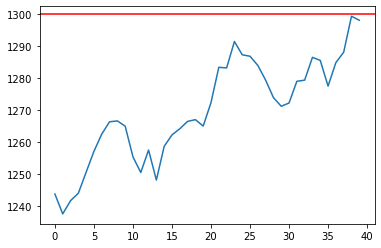

In [56]:
option_df.reset_index().S.plot()
plt.axhline(y=option_df["strike_price"].iloc[0] / 1000, color='r', linestyle='-')

In [57]:
option_df.shape

(40, 16)

In [58]:
# Get params dependent on data
strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

In [59]:
# Remaining params to determine
n_simulations = 10_000
rf = 0
fc_dims = [32, 32, 32]
LR = 0.005
EPOCHS = 20
BATCH_SIZE = 1000

In [60]:
# Using implied volatility should give back market price 
price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

(1.525, 0.6985203923660919)

In [61]:
bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=True)
optimizer = Adam(cn.parameters(), lr=LR)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.MSELoss()

dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
data_loader_train = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True)
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

Epoch 0: : 0batch [00:00, ?batch/s]/opt/anaconda3/envs/deep_hedging/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 10batch [00:05,  1.77batch/s, loss=15.1]
Epoch 1: : 10batch [00:05,  1.73batch/s, loss=5.63]
Epoch 2: : 10batch [00:05,  1.78batch/s, loss=3.75]
Epoch 3: : 10batch [00:05,  1.74batch/s, loss=2.54]
Epoch 4: : 10batch [00:05,  1.80batch/s, loss=2.22]
Epoch 5: : 10batch [00:06,  1.66batch/s, loss=2.16]
Epoch 6: : 10batch [00:05,  1.69batch/s, loss=3.31]
Epoch 7: : 10batch [00:06,  1.55batch/s, loss=2.25]
Epoch 8: : 10batch [00:05,  1.78batch/s, loss=2.59]
Epoch 9: : 10batch [00:05,  1.82batch/s, loss=3.04]
Epoch 10: : 10batch [00:05,  1.84batch/s, loss=2.34]
Epoch 11: : 10batch

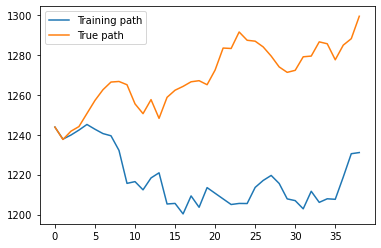

In [62]:
# Visualize an example training path and the true path

a, b, c, d, = next(iter(data_loader_train))
plt.plot(a[0], label="Training path")
plt.plot(x.squeeze(), label="True path")
plt.legend()

In [63]:
x.shape

torch.Size([1, 39, 1])

In [64]:
print(f"{price=}")

# Model
cn.eval_mode()

hedge, learned_price = cn(x)
si = stochastic_integral(torch.Tensor(x_inc), hedge)

print(f"{learned_price=}")  # this is roughly BS price using the imp. vola

ml_mkt_price = (price + si - payoff) ** 2
ml_learned_price = (learned_price + si - payoff) ** 2
print(f"{ml_mkt_price=}")
print(f"{ml_learned_price=}")

# Delta hedge benchmark
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
si = stochastic_integral(x_inc, d_hedge)
dl_mkt_price = (price + si - payoff) ** 2
dl_learned_price = (learned_price + si - payoff) ** 2
 
print(f"{dl_mkt_price=}")
print(f"{dl_learned_price=}")

price=1.525
learned_price=tensor([[1.5647]], grad_fn=<AddmmBackward>)
ml_mkt_price=tensor(13.3490, grad_fn=<PowBackward0>)
ml_learned_price=tensor([[13.6407]], grad_fn=<PowBackward0>)
dl_mkt_price=tensor(79.7735)
dl_learned_price=tensor([[80.4843]], grad_fn=<PowBackward0>)


In [110]:
# Remaining params to determine
n_simulations = 10_000
rf = 0
fc_dims = [32, 32, 32]
LR = 0.005
EPOCHS = 20
BATCH_SIZE = 1000

In [111]:
output = {}
for optionid in filenames:
    #Get data
    option_df = option_dfs[optionid]

    # Get params dependent on data
    strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

    # Using implied volatility should give back market price 
    price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

    #Train
    bs_params = {"n_simulations": n_simulations,
                 "n_steps": n_steps,
                 "initial_value": initial_value,
                 "sigma": sigma,
                 }

    price_params = {"n_steps": n_steps,
                    "initial_value": initial_value,
                    "sigma": sigma,
                    "rf": rf,
                    "strike": strike,
                    }

    payoff_params = {"strike": strike}

    cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=True)
    optimizer = Adam(cn.parameters(), lr=LR)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    criterion = torch.nn.MSELoss()

    dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
    data_loader_train = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True)
    train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

    # Model
    cn.eval_mode()

    hedge, learned_price = cn(x)
    si = stochastic_integral(torch.Tensor(x_inc), hedge)

    ml_mkt_price = (price + si - payoff) ** 2
    ml_learned_price = (learned_price + si - payoff) ** 2

    # Delta hedge benchmark
    def delta(x):
        return bs_delta(n_steps, x, sigma, rf, strike)

    d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
    si = stochastic_integral(x_inc, d_hedge)
    dl_mkt_price = (price + si - payoff) ** 2
    dl_learned_price = (learned_price + si - payoff) ** 2
    
    output[optionid] = [price, bs_call_price(n_steps, initial_value, sigma, rf, strike)\
                        , learned_price.detach().numpy()[0][0], ml_mkt_price.detach().numpy().item(0)\
                        , ml_learned_price.detach().numpy().item(0), dl_mkt_price.detach().numpy().item(0)\
                        , dl_learned_price.detach().numpy().item(0)]
    



Epoch 0: : 0batch [00:00, ?batch/s]/opt/anaconda3/envs/deep_hedging/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 10batch [00:07,  1.32batch/s, loss=5.21e+3]
Epoch 1: : 10batch [00:07,  1.29batch/s, loss=4.27e+3]
Epoch 2: : 10batch [00:07,  1.37batch/s, loss=3.53e+3]
Epoch 3: : 10batch [00:07,  1.39batch/s, loss=2.21e+3]
Epoch 4: : 10batch [00:07,  1.40batch/s, loss=633]   
Epoch 5: : 10batch [00:06,  1.44batch/s, loss=83.9]
Epoch 6: : 10batch [00:07,  1.36batch/s, loss=91.6]
Epoch 7: : 10batch [00:07,  1.39batch/s, loss=30] 
Epoch 8: : 10batch [00:07,  1.42batch/s, loss=29.8]
Epoch 9: : 10batch [00:07,  1.41batch/s, loss=18.9]
Epoch 10: : 10batch [00:06,  1.43batch/s, loss=19.6]
Epoch 

Epoch 7: : 10batch [00:09,  1.07batch/s, loss=3.49]
Epoch 8: : 10batch [00:09,  1.07batch/s, loss=3.86]
Epoch 9: : 10batch [00:09,  1.03batch/s, loss=3.14]
Epoch 10: : 10batch [00:09,  1.07batch/s, loss=1.72]
Epoch 11: : 10batch [00:09,  1.07batch/s, loss=2.6]
Epoch 12: : 10batch [00:09,  1.02batch/s, loss=1.65]
Epoch 13: : 10batch [00:09,  1.03batch/s, loss=2.59]
Epoch 14: : 10batch [00:09,  1.07batch/s, loss=2.15]
Epoch 15: : 10batch [00:09,  1.05batch/s, loss=2.48]
Epoch 16: : 10batch [00:09,  1.10batch/s, loss=2.18]
Epoch 17: : 10batch [00:09,  1.10batch/s, loss=1.58]
Epoch 18: : 10batch [00:09,  1.10batch/s, loss=1.54]
Epoch 19: : 10batch [00:09,  1.10batch/s, loss=1.78]
Epoch 0: : 10batch [00:10,  1.02s/batch, loss=520]   
Epoch 1: : 10batch [00:10,  1.03s/batch, loss=347]
Epoch 2: : 10batch [00:10,  1.01s/batch, loss=272]
Epoch 3: : 10batch [00:10,  1.02s/batch, loss=153]
Epoch 4: : 10batch [00:10,  1.03s/batch, loss=28.8]
Epoch 5: : 10batch [00:10,  1.02s/batch, loss=28.4]
Epoc

Epoch 2: : 10batch [00:09,  1.06batch/s, loss=7.87]
Epoch 3: : 10batch [00:09,  1.05batch/s, loss=5.79]
Epoch 4: : 10batch [00:09,  1.03batch/s, loss=3.81]
Epoch 5: : 10batch [00:09,  1.05batch/s, loss=4.44]
Epoch 6: : 10batch [00:09,  1.05batch/s, loss=3.59]
Epoch 7: : 10batch [00:09,  1.04batch/s, loss=3.94]
Epoch 8: : 10batch [00:09,  1.05batch/s, loss=3.38]
Epoch 9: : 10batch [00:09,  1.05batch/s, loss=2.81]
Epoch 10: : 10batch [00:09,  1.04batch/s, loss=5.78]
Epoch 11: : 10batch [00:09,  1.05batch/s, loss=3.24]
Epoch 12: : 10batch [00:09,  1.05batch/s, loss=3.04]
Epoch 13: : 10batch [00:09,  1.02batch/s, loss=5.53]
Epoch 14: : 10batch [00:09,  1.04batch/s, loss=2.77]
Epoch 15: : 10batch [00:09,  1.05batch/s, loss=2.94]
Epoch 16: : 10batch [00:09,  1.04batch/s, loss=2.72]
Epoch 17: : 10batch [00:09,  1.04batch/s, loss=3.44]
Epoch 18: : 10batch [00:09,  1.05batch/s, loss=2.71]
Epoch 19: : 10batch [00:10,  1.02s/batch, loss=4.12]
Epoch 0: : 10batch [00:06,  1.55batch/s, loss=264]   


Epoch 17: : 10batch [00:12,  1.29s/batch, loss=12.3]
Epoch 18: : 10batch [00:12,  1.28s/batch, loss=12.1]
Epoch 19: : 10batch [00:12,  1.27s/batch, loss=10.8]
Epoch 0: : 10batch [00:07,  1.33batch/s, loss=34.6]
Epoch 1: : 10batch [00:07,  1.35batch/s, loss=11.2]
Epoch 2: : 10batch [00:07,  1.33batch/s, loss=6.24]
Epoch 3: : 10batch [00:07,  1.34batch/s, loss=4.81]
Epoch 4: : 10batch [00:07,  1.31batch/s, loss=4.88]
Epoch 5: : 10batch [00:07,  1.29batch/s, loss=4.99]
Epoch 6: : 10batch [00:07,  1.34batch/s, loss=4.84]
Epoch 7: : 10batch [00:07,  1.33batch/s, loss=2.95]
Epoch 8: : 10batch [00:07,  1.37batch/s, loss=3.75]
Epoch 9: : 10batch [00:07,  1.36batch/s, loss=4.01]
Epoch 10: : 10batch [00:07,  1.32batch/s, loss=3.38]
Epoch 11: : 10batch [00:07,  1.41batch/s, loss=3.31]
Epoch 12: : 10batch [00:07,  1.34batch/s, loss=3.05]
Epoch 13: : 10batch [00:07,  1.35batch/s, loss=3.02]
Epoch 14: : 10batch [00:07,  1.29batch/s, loss=3.56]
Epoch 15: : 10batch [00:07,  1.39batch/s, loss=3.15]
Epo

In [113]:
df_output = pd.DataFrame.from_dict(output, orient='index', columns=['price', 'bs_call_price', 'learned_price', 'ml_mkt_price', 'ml_learned_price', 'dl_mkt_price', 'dl_learned_price'])

In [114]:
df_output.to_csv('output.csv')